In [32]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import SVC

In [34]:
trip = pd.read_csv("../data/clean/trip.csv")

# Drop any columns with the string "id" or "flag" in them
for col in trip:
  if "id" in col:
    trip = trip.drop(col, axis=1)

# Drop these columns: 'reason_for_travel_to', 'why_trip', 'trip_purpose_old_schema'
trip = trip.drop(['trip_purpose_old_schema', 'why_trip', 'reason_for_travel_to'], axis=1)

# Prepare trip data for model
label_encoder = LabelEncoder()
scaler = MinMaxScaler()

for col in trip.columns.drop('trip_purpose'):
  if trip[col].dtype == object:
    trip[col] = label_encoder.fit_transform(trip[col])
  else: # Normalize
    trip[col] = scaler.fit_transform(trip[col].values.reshape(-1, 1))

# Remove rows where trip purpose is "Not Ascertained"
trip = trip[trip["trip_purpose"] != "Not ascertained"]
trip = trip.reset_index(drop=True)

vis = trip["trip_purpose"].astype('category')

trip["trip_purpose"] = label_encoder.fit_transform(trip["trip_purpose"])
target = trip["trip_purpose"].to_numpy()
features = trip.drop('trip_purpose', axis=1).to_numpy()

# Set random seed
np.random.seed(1989)

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

# Create validation data as 10% of training data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

In [5]:
# Create LSTM model
model = keras.Sequential()
model.add(layers.Input(shape=(features.shape[1],)))
# add convolutional layer
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(
    x_train,
    y_train,
    epochs=500,
    batch_size=32,
    callbacks=keras.callbacks.EarlyStopping(patience=2),
    validation_data=(x_val, y_val)
)

predictions = model.predict(x_test, verbose=0)
# Save the model
NN_preds = np.argmax(predictions, axis=1)
loss, NN_accuracy = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/500
629/629 [==============================] - 6s 9ms/step - loss: 1.3884 - accuracy: 0.3823 - val_loss: 1.2797 - val_accuracy: 0.4428
Epoch 2/500
629/629 [==============================] - 5s 8ms/step - loss: 1.2206 - accuracy: 0.4583 - val_loss: 1.1381 - val_accuracy: 0.4848
Epoch 3/500
629/629 [==============================] - 5s 8ms/step - loss: 1.1196 - accuracy: 0.4957 - val_loss: 1.1035 - val_accuracy: 0.4826
Epoch 4/500
629/629 [==============================] - 5s 8ms/step - loss: 1.0609 - accuracy: 0.5183 - val_loss: 1.0309 - val_accuracy: 0.5188
Epoch 5/500
629/629 [==============================] - 5s 8ms/step - loss: 1.0327 - accuracy: 0.5252 - val_loss: 0.9968 - val_accuracy: 0.5148
Epoch 6/500
629/629 [==============================] - 5s 8ms/step - loss: 1.0115 - accuracy: 0.5327 - val_loss: 1.0234 - val_accuracy: 0.5233
Epoch 7/500
629/629 [==============================] - 5s 8ms/step - loss: 0.9928 - accuracy: 0.5392 - val_loss: 0.9557 - val_accuracy: 0.5510

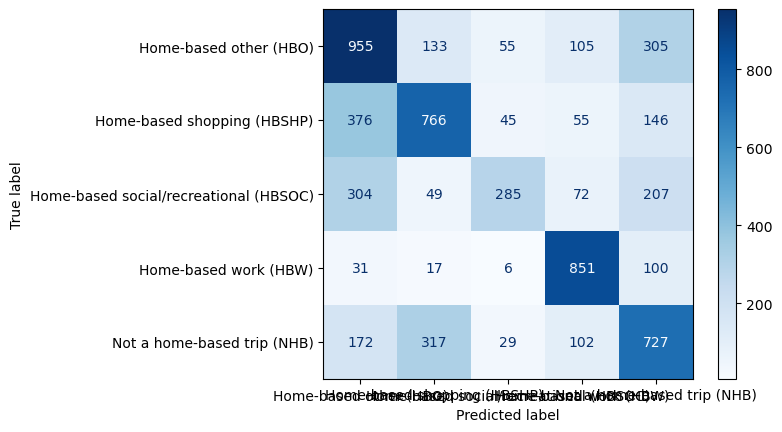

                                        precision    recall  f1-score   support

                Home-based other (HBO)       0.52      0.61      0.56      1553
           Home-based shopping (HBSHP)       0.60      0.55      0.57      1388
Home-based social/recreational (HBSOC)       0.68      0.31      0.43       917
                 Home-based work (HBW)       0.72      0.85      0.78      1005
           Not a home-based trip (NHB)       0.49      0.54      0.51      1347

                              accuracy                           0.58      6210
                             macro avg       0.60      0.57      0.57      6210
                          weighted avg       0.59      0.58      0.57      6210



In [13]:
# Create confusion matrix
cm = confusion_matrix(y_test, NN_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vis.cat.categories)
disp.plot(cmap='Blues')
plt.show()

# Create classification report
print(classification_report(y_test, NN_preds, target_names=vis.cat.categories))

In [7]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

lr_model = LogisticRegression()

grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
logit_pred = best_model.predict(x_test)
y_pred = best_model.predict(x_test)
Logit_accuracy = accuracy_score(y_test, y_pred)

/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mariongeary/anaconda3/envs/dsan6600/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

In [8]:
print(best_params)
print(best_model)

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression(C=10, penalty='l1', solver='liblinear')


In [10]:
# Save sklearn model
import pickle

pickle.dump(best_model, open("../models/logit_model.pkl", "wb"))

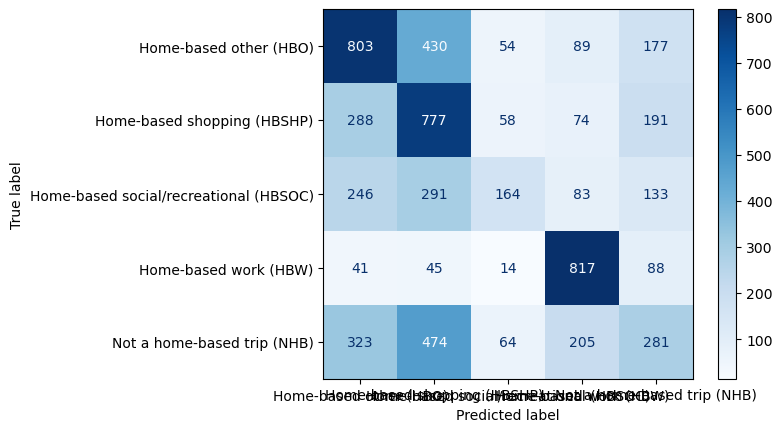

                                        precision    recall  f1-score   support

                Home-based other (HBO)       0.47      0.52      0.49      1553
           Home-based shopping (HBSHP)       0.39      0.56      0.46      1388
Home-based social/recreational (HBSOC)       0.46      0.18      0.26       917
                 Home-based work (HBW)       0.64      0.81      0.72      1005
           Not a home-based trip (NHB)       0.32      0.21      0.25      1347

                              accuracy                           0.46      6210
                             macro avg       0.46      0.46      0.44      6210
                          weighted avg       0.45      0.46      0.43      6210



In [12]:
# Create confusion matrix
cm = confusion_matrix(y_test, logit_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vis.cat.categories)
disp.plot(cmap='Blues')
plt.show()

# Create classification report
print(classification_report(y_test, logit_pred, target_names=vis.cat.categories))

In [14]:
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

model1 = xgb.XGBClassifier()
grid_search = RandomizedSearchCV(estimator=model1, param_distributions=param_grid, n_iter=20, scoring='accuracy', cv=3)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_

xgboost_model = xgb.XGBClassifier(**best_params)
xgboost_model.fit(x_train, y_train)

agboost_pred = xgboost_model.predict(x_test)
xgboost_accuracy = accuracy_score(y_test, agboost_pred)

In [15]:
# Save sklearn model
pickle.dump(xgboost_model, open("../models/xgboost_model.pkl", "wb"))

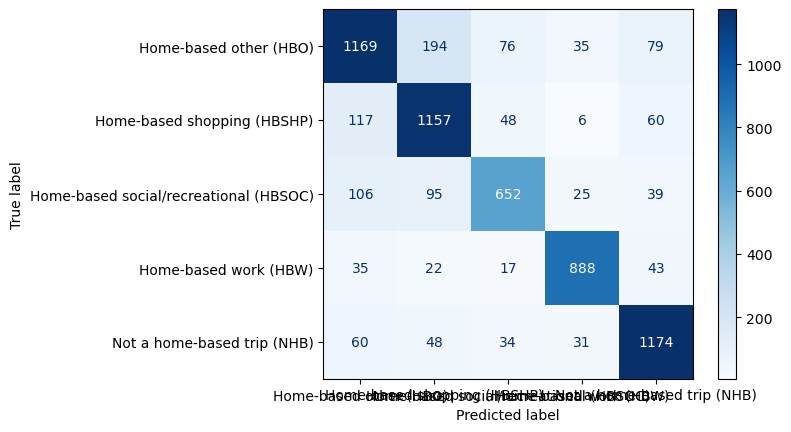

                                        precision    recall  f1-score   support

                Home-based other (HBO)       0.79      0.75      0.77      1553
           Home-based shopping (HBSHP)       0.76      0.83      0.80      1388
Home-based social/recreational (HBSOC)       0.79      0.71      0.75       917
                 Home-based work (HBW)       0.90      0.88      0.89      1005
           Not a home-based trip (NHB)       0.84      0.87      0.86      1347

                              accuracy                           0.81      6210
                             macro avg       0.82      0.81      0.81      6210
                          weighted avg       0.81      0.81      0.81      6210



In [16]:
# Create confusion matrix
cm = confusion_matrix(y_test, agboost_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vis.cat.categories)
disp.plot(cmap='Blues')
plt.show()

# Create classification report
print(classification_report(y_test, agboost_pred, target_names=vis.cat.categories))

In [17]:
best_c = 10
best_kernel = "poly"
svc = SVC(C=best_c, kernel=best_kernel)
svc.fit(x_train, y_train)

SVM_pred = svc.predict(x_test)
svm_accuracy = accuracy_score(y_test, SVM_pred)

In [18]:
# Save sklearn model
pickle.dump(svc, open("../models/svm_model.pkl", "wb"))

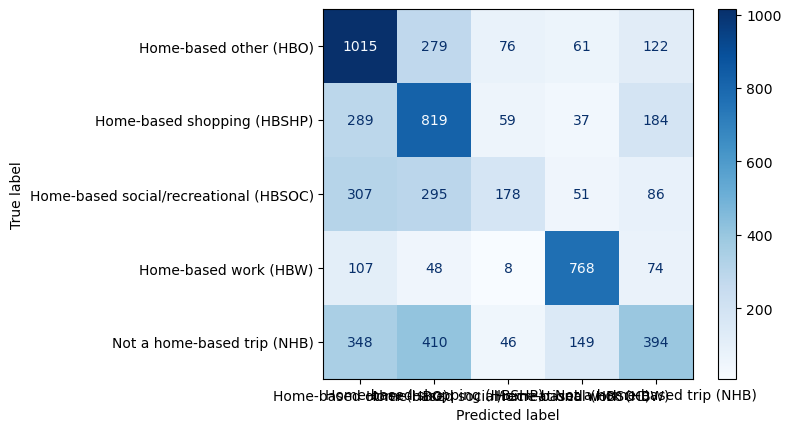

                                        precision    recall  f1-score   support

                Home-based other (HBO)       0.49      0.65      0.56      1553
           Home-based shopping (HBSHP)       0.44      0.59      0.51      1388
Home-based social/recreational (HBSOC)       0.49      0.19      0.28       917
                 Home-based work (HBW)       0.72      0.76      0.74      1005
           Not a home-based trip (NHB)       0.46      0.29      0.36      1347

                              accuracy                           0.51      6210
                             macro avg       0.52      0.50      0.49      6210
                          weighted avg       0.51      0.51      0.49      6210



In [19]:
# Create confusion matrix
cm = confusion_matrix(y_test, SVM_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vis.cat.categories)
disp.plot(cmap='Blues')
plt.show()

# Create classification report
print(classification_report(y_test, SVM_pred, target_names=vis.cat.categories))

## Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': list(range(1,15)),
    'min_samples_split': list(range(2,6))
}
rf = RandomForestClassifier(n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_

rf_model = RandomForestClassifier(**best_params)
rf_model.fit(x_train, y_train)

rf_pred = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

In [43]:
# Save sklearn model
pickle.dump(rf_model, open("../models/rf_model.pkl", "wb"))

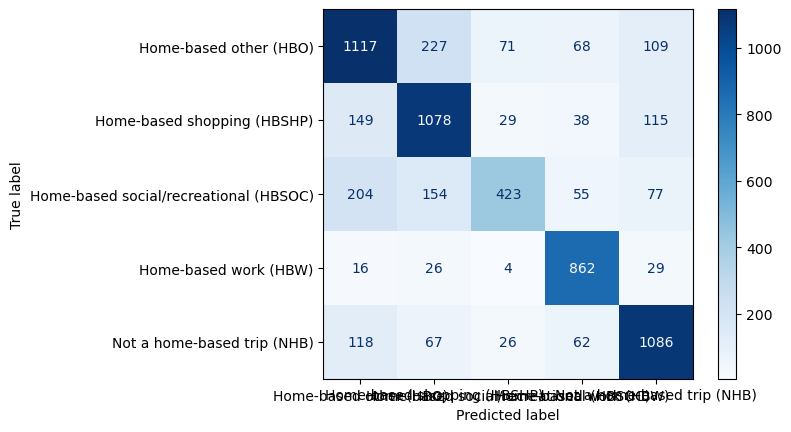

                                        precision    recall  f1-score   support

                Home-based other (HBO)       0.70      0.70      0.70      1592
           Home-based shopping (HBSHP)       0.69      0.77      0.73      1409
Home-based social/recreational (HBSOC)       0.76      0.46      0.58       913
                 Home-based work (HBW)       0.79      0.92      0.85       937
           Not a home-based trip (NHB)       0.77      0.80      0.78      1359

                              accuracy                           0.74      6210
                             macro avg       0.74      0.73      0.73      6210
                          weighted avg       0.74      0.74      0.73      6210



In [44]:
# Create confusion matrix
cm = confusion_matrix(y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vis.cat.categories)
disp.plot(cmap='Blues')
plt.show()

# Create classification report
print(classification_report(y_test, rf_pred, target_names=vis.cat.categories))

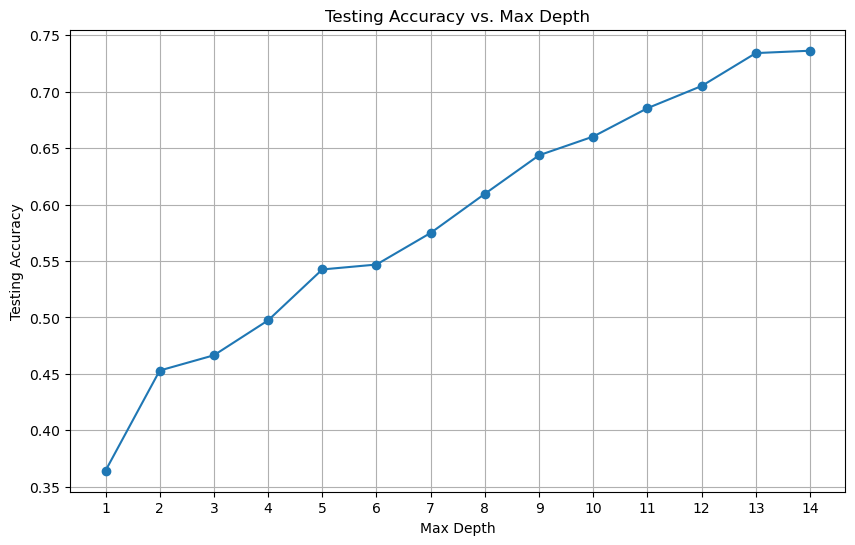

In [45]:
import matplotlib.pyplot as plt

# Initialize lists to store max depth and testing accuracies
max_depth_values = []
test_accuracies = []

# Iterate over different max depth values
for max_depth in range(1, 15):
    # Initialize the random forest classifier with the current max depth
    rf = RandomForestClassifier(max_depth=max_depth, min_samples_split=3, n_estimators=100)
    
    # Fit the model
    rf.fit(x_train, y_train)
    
    # Evaluate the model on the test set
    test_accuracy = rf.score(x_test, y_test)
    
    # Append max depth and corresponding test accuracy to the lists
    max_depth_values.append(max_depth)
    test_accuracies.append(test_accuracy)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, test_accuracies, marker='o')
plt.title('Testing Accuracy vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Testing Accuracy')
plt.xticks(max_depth_values)
plt.grid(True)
plt.show()

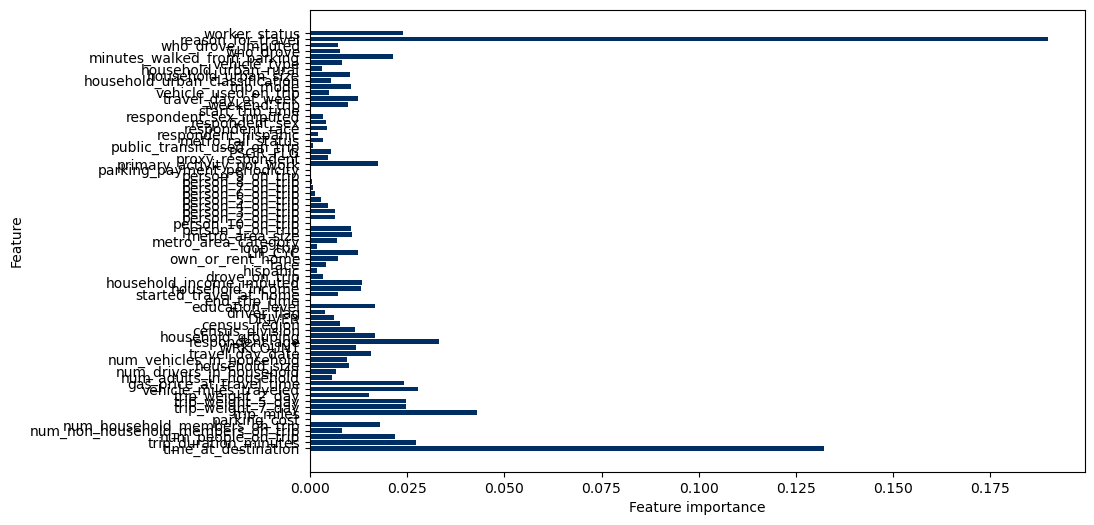

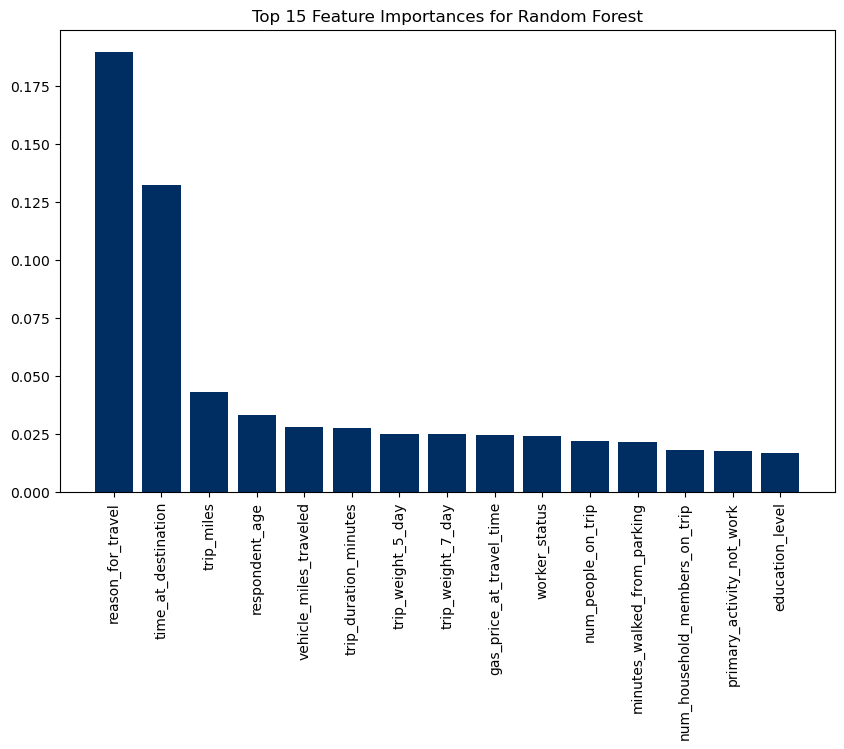

In [61]:
### Feature Importance plot
def plot_feature_importances(model, feature_names):
    n_features = len(feature_names)
    plt.figure(figsize=(10, 6))  
    plt.barh(range(n_features), model.feature_importances_, align='center', color = "#002e62")
    plt.yticks(range(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.show()

# convert x_train to a DataFrame
x_train_df = pd.DataFrame(x_train, columns=trip.drop('trip_purpose', axis=1).columns)


plot_feature_importances(rf, x_train_df.columns)

# Plot the top n most important features as lollipop plot
n = 15
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title(f'Top {n} Feature Importances for Random Forest')
plt.bar(range(n), importances[indices[:n]], color = "#002e62")
plt.xticks(range(n), x_train_df.columns[indices[:n]], rotation=90)
plt.show()

195/195 [==============================] - 0s 2ms/step


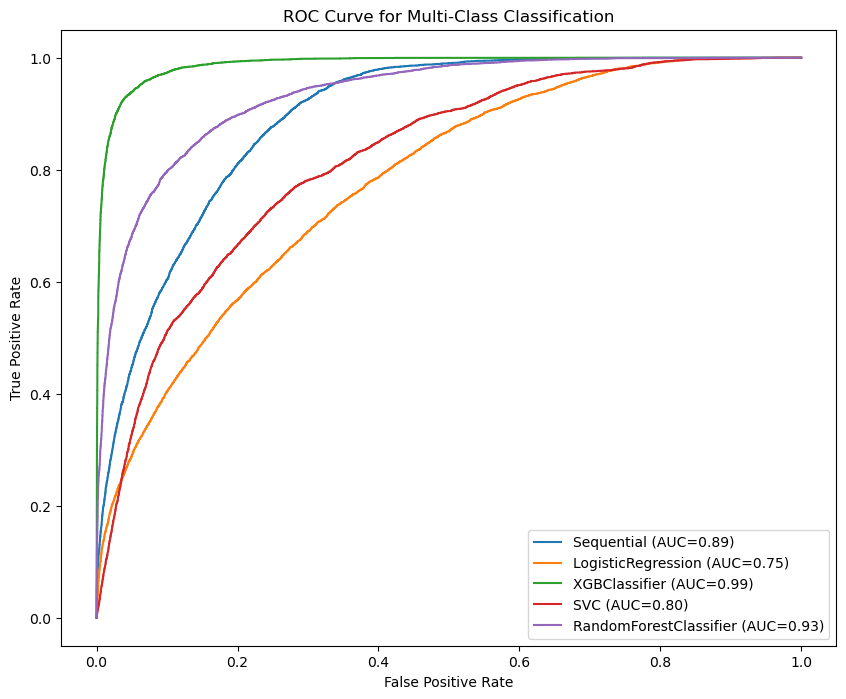

In [62]:
from sklearn.preprocessing import label_binarize

models = [model, best_model, xgboost_model, svc, rf_model]
fig, ax = plt.subplots(figsize=(10, 8))
for mod in models:
    y_test_binary = label_binarize(y_test, classes=np.unique(y_test))
    if hasattr(mod, 'predict_proba'):
        y_pred_proba = mod.predict_proba(x_test)
    elif hasattr(mod, 'decision_function'):
        y_pred_proba = mod.decision_function(x_test)
    else:
        y_pred_proba = model.predict(x_test)
    fpr, tpr, _ = roc_curve(y_test_binary.ravel(), y_pred_proba.ravel())
    roc_auc = roc_auc_score(y_test_binary, y_pred_proba)
    ax.plot(fpr, tpr, label=f"{type(mod).__name__} (AUC={roc_auc:.2f})")

ax.set_title('ROC Curve for Multi-Class Classification')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.show()

In [63]:
print(f"NN Accuracy: {NN_accuracy}")
print(f"Logistic regression accuracy: {Logit_accuracy}")
print(f"Xgboost accuracy: {xgboost_accuracy}")
print(f"SVM accuracy: {svm_accuracy}")
print(f"Random Forest accuracy: {rf_accuracy}")

NN Accuracy: 0.5771336555480957
Logistic regression accuracy: 0.4576489533011272
Xgboost accuracy: 0.8115942028985508
SVM accuracy: 0.5111111111111111
Random Forest accuracy: 0.7352657004830918


In [64]:
# Save all model predictions and actual values
model_preds = {
    "NN": NN_preds,
    "Logistic Regression": logit_pred,
    "Xgboost": agboost_pred,
    "SVM": SVM_pred,
    "RF": rf_pred,
    "Actual": y_test
}

model_preds_df = pd.DataFrame(model_preds)

model_preds_df.to_csv("../data/model_predictions.csv", index=False)

In [70]:
# Save model probabilities as long format. Each column is the probability of a class
nn_probs = {
    f"NN_{i}": predictions[:, i] for i in range(5)
}

nn_probs_df = pd.DataFrame(nn_probs)

nn_probs_df.to_csv("../data/nn_probs.csv", index=False)

logit_probs = best_model.predict_proba(x_test)
logit_probs_df = pd.DataFrame(logit_probs, columns=[f"Logit_{i}" for i in range(5)])
logit_probs_df.to_csv("../data/logit_probs.csv", index=False)

xgboost_probs = xgboost_model.predict_proba(x_test)
xgboost_probs_df = pd.DataFrame(xgboost_probs, columns=[f"Xgboost_{i}" for i in range(5)])
xgboost_probs_df.to_csv("../data/xgboost_probs.csv", index=False)

svm_probs = svc.decision_function(x_test)
svm_probs_df = pd.DataFrame(svm_probs, columns=[f"SVM_{i}" for i in range(5)])
svm_probs_df.to_csv("../data/svm_probs.csv", index=False)

rf_probs = rf_model.predict_proba(x_test)
rf_probs_df = pd.DataFrame(rf_probs, columns=[f"RF_{i}" for i in range(5)])
rf_probs_df.to_csv("../data/rf_probs.csv", index=False)

# Combine all into one dataframe
all_probs = pd.concat([nn_probs_df, logit_probs_df, xgboost_probs_df, svm_probs_df, rf_probs_df, model_preds_df], axis=1)
all_probs.to_csv("../data/all_probs.csv", index=False)

In [29]:
# List predict class names
print(vis.cat.categories)

Index(['Home-based other (HBO)', 'Home-based shopping (HBSHP)',
       'Home-based social/recreational (HBSOC)', 'Home-based work (HBW)',
       'Not a home-based trip (NHB)'],
      dtype='object')
